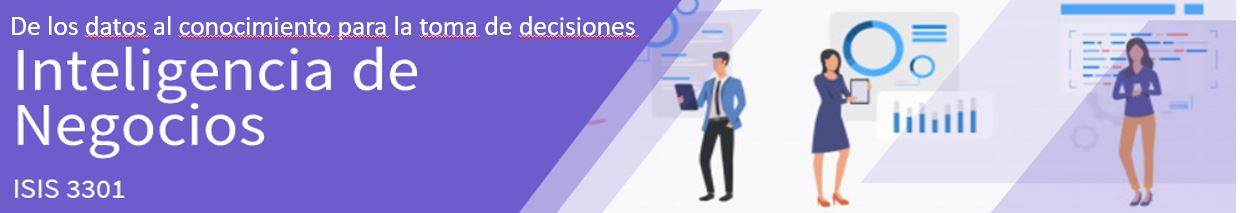

## Caso

AlpesGamesInsight es una empresa dedicada a la cobertura y análisis de diferentes competencias de video juegos profesionales. Uno de sus factores diferenciadores es el cálculo de un ranking de los diferentes jugadores por video juego. Este ranking sirve como referencia para los equipos en el momento de seleccionar jugadores para competir y para los patrocinadores quienes apoyan económicamente las carreras de los jugadores.

Durante años esta empresa ha realizado este proceso de forma manual, basándose en grupos de expertos que asignan un LeagueIndex a cada uno de los jugadores profesionales.
El equipo in house de analítica ha realizado diferentes ejercicios de estimación automática en el pasado, pero sin mucho éxito, logrando únicamente un  R2 de 0.35. Es precisamente por esto que han contratado a su equipo, ya que quieren tener una opinión experta sobre la posibilidad de extraer este ranking de forma automática, usando aprendizaje supervisado. Su tarea consiste en estudiar el desempeño de un modelo de regresión para predecir la variable, evaluar su viabilidad e identificar las características que mas afectan el ranking de un jugador.

## 1. Carga de librerías necesarias para implementación

In [1]:
seed = 161
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Composicion de pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split

# Regresion lineal
from sklearn.linear_model import LinearRegression

# Para sacar un reporte estadístico que podemos usar para determinar las importancia de las variables explicativas.
import statsmodels.api as sm 

# Importar/ Exportar modelos
from joblib import dump, load

# Metricas
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error as mse

# q-q plots
import scipy.stats as stats

## 2. Cargar y limpieza de los datos

In [2]:
# Se cargan los datos. 
df_original = pd.read_csv('202120_Laboratorio_3_data_SkillCraftHistoric.csv')
df_tracks = df_original.copy()
print(df_tracks.shape)
df_tracks.head(5)

(3238, 19)


,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,6.429631,27,10,3000,143.718,0.0035151591,0.0002196974,7,0.0001098487,0.0003923169,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.0
1,6.034862,23,10,5000,129.2322,0.0033038124,0.0002594617,4,0.0002940566,0.0004324362,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.00020757
2,5.000659,30,10,200,69.9612,0.0011010906,0.0003355705,4,0.0002936242,0.0004614094,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.00018876
3,3.264122,19,20,400,107.6016,0.0010335422,0.0002131015,1,5.32753697310659e-05,0.0005434088,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.00038358
4,3.883553,32,10,500,122.8908,0.0011360136,0.0003273259,2,0.0,0.0013285582,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,1.9254e-05


In [3]:
df_recent = pd.read_csv('202120_Laboratorio_3_data_SkillCraftRecent.csv')
print(df_recent.shape)
df_recent.head(5)

(103, 18)


,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,16,24,300,81.0702,0.001747,0.000104,0,0.000026,0.000143,0.002620,47.4800,75.0846,5.0796,14,0.000808,6,0.000026,0.000039
1,22,20,1200,120.7014,0.005496,0.000240,5,0.000000,0.000022,0.003613,44.8387,60.9175,4.8089,31,0.000516,5,0.000000,0.000000
2,20,24,233,69.1764,0.000331,0.000026,0,0.000093,0.000198,0.001997,44.1333,93.4040,6.3113,15,0.000489,4,0.000000,0.000000
3,22,10,500,67.1406,0.001152,0.000260,5,0.000000,0.000056,0.003846,56.5437,55.7295,3.0290,15,0.001133,3,0.000000,0.000000
4,17,8,400,87.5310,0.001468,0.000264,4,0.000000,0.000169,0.003464,59.3443,53.3478,4.2609,13,0.000998,7,0.000000,0.000320


Vamos a ver los tipos de datos que tienen ambas colecciones de datos para identificar posibles errores

In [4]:
df_recent.dtypes

Age                       int64
HoursPerWeek              int64
TotalHours                int64
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

In [5]:
df_tracks.dtypes

LeagueIndex             float64
Age                      object
HoursPerWeek             object
TotalHours               object
APM                      object
SelectByHotkeys          object
AssignToHotkeys          object
UniqueHotkeys            object
MinimapAttacks           object
MinimapRightClicks       object
NumberOfPACs            float64
GapBetweenPACs           object
ActionLatency            object
ActionsInPAC            float64
TotalMapExplored         object
WorkersMade             float64
UniqueUnitsMade          object
ComplexUnitsMade         object
ComplexAbilitiesUsed     object
dtype: object

Vemos que para el caso de df_recent tenemos tipos de datos acordes a los del diccinario, sin embargo para df_tracks tenemos varios errores, es por esto que valos a eliminar las filas con valores nulos.

In [6]:
df_tracks.shape

(3238, 19)

In [7]:
indexNames = df_tracks[df_tracks['Age'] == 'NA-VALUE'].index
df_tracks = df_tracks.drop(indexNames)
df_tracks.shape

(3237, 19)

In [8]:
df_tracks['Age']=df_tracks['Age'].astype(int)

In [9]:
indexNames = df_tracks[df_tracks['HoursPerWeek'] == 'NA-VALUE'].index
df_tracks = df_tracks.drop(indexNames)
df_tracks.shape

(3236, 19)

In [10]:
df_tracks['HoursPerWeek']=df_tracks['HoursPerWeek'].astype(int)

In [11]:
indexNames = df_tracks[df_tracks['TotalHours'] == 'NA-VALUE'].index
df_tracks = df_tracks.drop(indexNames)
df_tracks.shape

(3235, 19)

In [12]:
df_tracks['TotalHours']=df_tracks['TotalHours'].astype(int)

In [13]:
indexNames = df_tracks[df_tracks['APM'] == 'NA-VALUE'].index
df_tracks = df_tracks.drop(indexNames)
df_tracks.shape

(3234, 19)

In [14]:
df_tracks['APM']=df_tracks['APM'].astype(float)

In [15]:
indexNames = df_tracks[df_tracks['SelectByHotkeys'] == 'NA-VALUE'].index
df_tracks = df_tracks.drop(indexNames)
df_tracks.shape

(3232, 19)

In [16]:
df_tracks['SelectByHotkeys']=df_tracks['SelectByHotkeys'].astype(float)

In [17]:
indexNames = df_tracks[df_tracks['AssignToHotkeys'] == 'NA-VALUE'].index
df_tracks = df_tracks.drop(indexNames)
df_tracks.shape

(3231, 19)

In [18]:
df_tracks['AssignToHotkeys']=df_tracks['AssignToHotkeys'].astype(float)

In [19]:
indexNames = df_tracks[df_tracks['UniqueHotkeys'] == 'NA-VALUE'].index
df_tracks = df_tracks.drop(indexNames)
indexNames = df_tracks[df_tracks['MinimapAttacks'] == 'NA-VALUE'].index
df_tracks = df_tracks.drop(indexNames)
indexNames = df_tracks[df_tracks['MinimapRightClicks'] == 'NA-VALUE'].index
df_tracks = df_tracks.drop(indexNames)
df_tracks.shape

(3227, 19)

In [20]:
df_tracks['UniqueHotkeys']=df_tracks['UniqueHotkeys'].astype(int)
df_tracks['MinimapAttacks']=df_tracks['MinimapAttacks'].astype(float)
df_tracks['MinimapRightClicks']=df_tracks['MinimapRightClicks'].astype(float)
df_tracks.dtypes

LeagueIndex             float64
Age                       int32
HoursPerWeek              int32
TotalHours                int32
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int32
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs           object
ActionLatency            object
ActionsInPAC            float64
TotalMapExplored         object
WorkersMade             float64
UniqueUnitsMade          object
ComplexUnitsMade         object
ComplexAbilitiesUsed     object
dtype: object

In [21]:
indexNames = df_tracks[df_tracks['GapBetweenPACs'] == 'NA-VALUE'].index
df_tracks = df_tracks.drop(indexNames)
indexNames = df_tracks[df_tracks['ActionLatency'] == 'NA-VALUE'].index
df_tracks = df_tracks.drop(indexNames)
indexNames = df_tracks[df_tracks['TotalMapExplored'] == 'NA-VALUE'].index
df_tracks = df_tracks.drop(indexNames)
df_tracks.shape
df_tracks['GapBetweenPACs']=df_tracks['GapBetweenPACs'].astype(float)
df_tracks['ActionLatency']=df_tracks['ActionLatency'].astype(float)
df_tracks['TotalMapExplored']=df_tracks['TotalMapExplored'].astype(int)
df_tracks.dtypes

LeagueIndex             float64
Age                       int32
HoursPerWeek              int32
TotalHours                int32
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int32
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int32
WorkersMade             float64
UniqueUnitsMade          object
ComplexUnitsMade         object
ComplexAbilitiesUsed     object
dtype: object

In [22]:
indexNames = df_tracks[df_tracks['UniqueUnitsMade'] == 'NA-VALUE'].index
df_tracks = df_tracks.drop(indexNames)
indexNames = df_tracks[df_tracks['ComplexUnitsMade'] == 'NA-VALUE'].index
df_tracks = df_tracks.drop(indexNames)
indexNames = df_tracks[df_tracks['ComplexAbilitiesUsed'] == 'NA-VALUE'].index
df_tracks = df_tracks.drop(indexNames)
df_tracks.shape
df_tracks['UniqueUnitsMade']=df_tracks['UniqueUnitsMade'].astype(int)
df_tracks['ComplexUnitsMade']=df_tracks['ComplexUnitsMade'].astype(float)
df_tracks['ComplexAbilitiesUsed']=df_tracks['ComplexAbilitiesUsed'].astype(float)
df_tracks.dtypes

LeagueIndex             float64
Age                       int32
HoursPerWeek              int32
TotalHours                int32
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int32
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int32
WorkersMade             float64
UniqueUnitsMade           int32
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

In [23]:
df_tracks.shape

(3216, 19)

In [24]:
# ¿Hay ausencias?
df_tracks.isna().sum()/len(df_tracks)

LeagueIndex             0.0
Age                     0.0
HoursPerWeek            0.0
TotalHours              0.0
APM                     0.0
SelectByHotkeys         0.0
AssignToHotkeys         0.0
UniqueHotkeys           0.0
MinimapAttacks          0.0
MinimapRightClicks      0.0
NumberOfPACs            0.0
GapBetweenPACs          0.0
ActionLatency           0.0
ActionsInPAC            0.0
TotalMapExplored        0.0
WorkersMade             0.0
UniqueUnitsMade         0.0
ComplexUnitsMade        0.0
ComplexAbilitiesUsed    0.0
dtype: float64

In [25]:
# ¿Hay duplicados?
df_tracks.duplicated(keep = 'first').sum()

0

## 3. Perfilamiento y Entendimiento de los Datos 

Para las regresiones lineales, es necesario trabajar con variables numéricas. 

In [26]:
df_num = df_tracks.select_dtypes(['number']).copy()
df_num.describe()

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000
mean,5.867998,21.673507,15.924751,974.362562,115.303658,0.004075,0.000367,4.345460,0.000095,0.000385,0.003445,40.630414,64.060245,5.276654,22.233520,0.001038,6.569030,0.000062,0.000145
std,3.108503,4.239677,11.943592,17642.729046,48.402107,0.004766,0.000211,2.343264,0.000160,0.000363,0.000972,17.159899,19.158868,1.508501,7.472617,0.000525,1.859169,0.000113,0.000269
min,0.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.632600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,4.124558,19.000000,8.000000,300.000000,79.958400,0.001258,0.000204,3.000000,0.000000,0.000142,0.002752,29.218875,50.567725,4.263550,17.000000,0.000685,5.000000,0.000000,0.000000
50%,5.681340,21.000000,12.000000,500.000000,107.981100,0.002484,0.000351,4.000000,0.000040,0.000283,0.003390,36.964950,61.125800,5.093550,22.000000,0.000909,6.000000,0.000000,0.000022
75%,7.089782,24.000000,20.000000,800.000000,141.630600,0.004982,0.000495,6.000000,0.000117,0.000513,0.004019,48.453425,73.864475,6.035100,27.000000,0.001268,8.000000,0.000090,0.000187
max,20.000000,44.000000,168.000000,1000000.000000,389.831400,0.043088,0.001648,10.000000,0.003019,0.003688,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


In [27]:
# Eliminamos los registros que tienen la variable objetivo nula LeagueIndex
df_tracks = df_tracks.dropna(subset = ['LeagueIndex'])
df_tracks.describe()

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000
mean,5.867998,21.673507,15.924751,974.362562,115.303658,0.004075,0.000367,4.345460,0.000095,0.000385,0.003445,40.630414,64.060245,5.276654,22.233520,0.001038,6.569030,0.000062,0.000145
std,3.108503,4.239677,11.943592,17642.729046,48.402107,0.004766,0.000211,2.343264,0.000160,0.000363,0.000972,17.159899,19.158868,1.508501,7.472617,0.000525,1.859169,0.000113,0.000269
min,0.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.632600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,4.124558,19.000000,8.000000,300.000000,79.958400,0.001258,0.000204,3.000000,0.000000,0.000142,0.002752,29.218875,50.567725,4.263550,17.000000,0.000685,5.000000,0.000000,0.000000
50%,5.681340,21.000000,12.000000,500.000000,107.981100,0.002484,0.000351,4.000000,0.000040,0.000283,0.003390,36.964950,61.125800,5.093550,22.000000,0.000909,6.000000,0.000000,0.000022
75%,7.089782,24.000000,20.000000,800.000000,141.630600,0.004982,0.000495,6.000000,0.000117,0.000513,0.004019,48.453425,73.864475,6.035100,27.000000,0.001268,8.000000,0.000090,0.000187
max,20.000000,44.000000,168.000000,1000000.000000,389.831400,0.043088,0.001648,10.000000,0.003019,0.003688,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


### 3.1 Búsqueda de relaciones entre variables (diagramas de dispersión)

Buscamos cuales de las columnas tienen una *relacion* con LeagueIndex

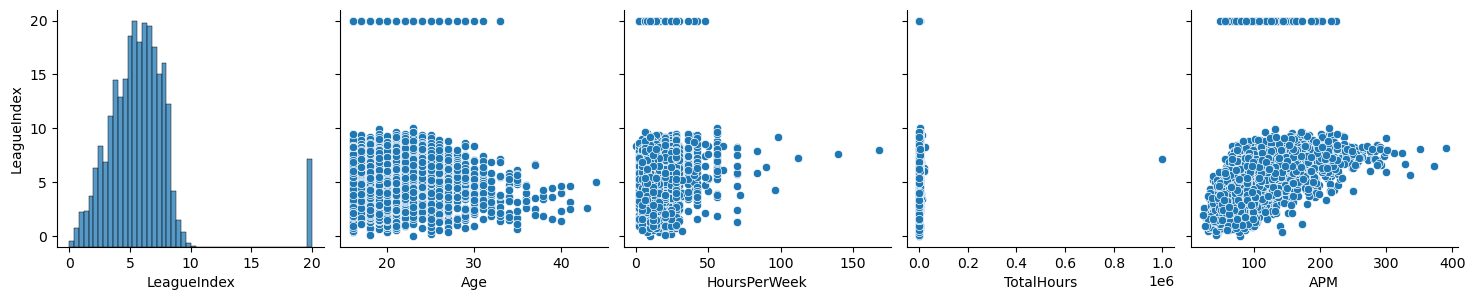

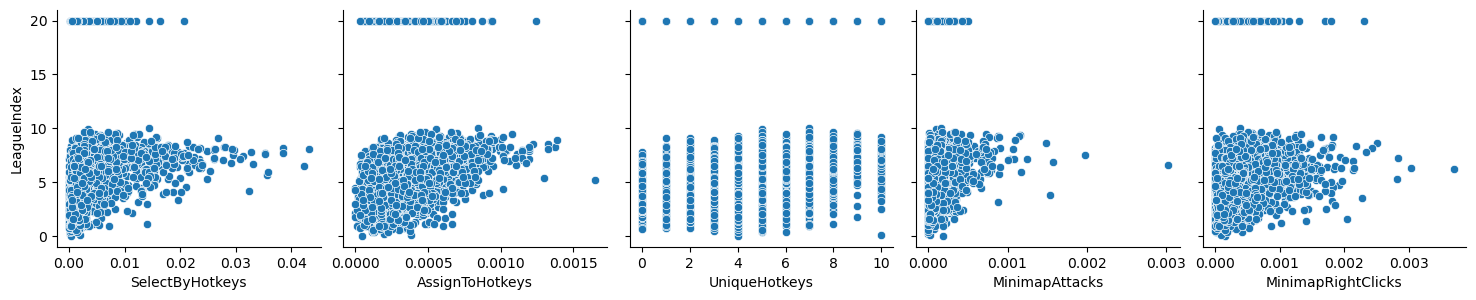

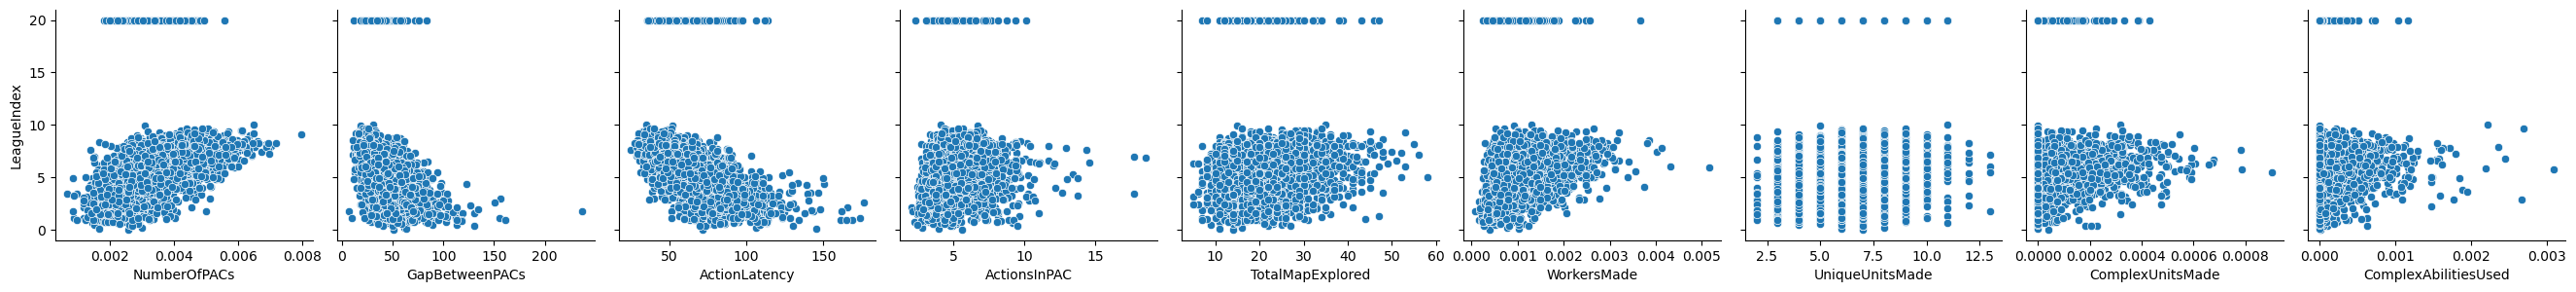

In [28]:
sns.pairplot(df_num, height=3, y_vars = 'LeagueIndex', x_vars = df_num.columns[0:5], kind='scatter')
sns.pairplot(df_num, height=3, y_vars = 'LeagueIndex', x_vars = df_num.columns[5:10], kind='scatter')
sns.pairplot(df_num, height=3, y_vars = 'LeagueIndex', x_vars = df_num.columns[10:], kind='scatter')
plt.show()

De las graficas anteriores vemos que unos buenos candidatos son:
* APM
* AssignToHotkeys
* GapBetweenPACs
* ActionLatency

### 3.2 Búsqueda de relaciones entre variables (Matriz de correlaciones)

Buscamos cuales de las columnas tienen una *relacion* con LeagueIndex pero ahora usando correlaciones

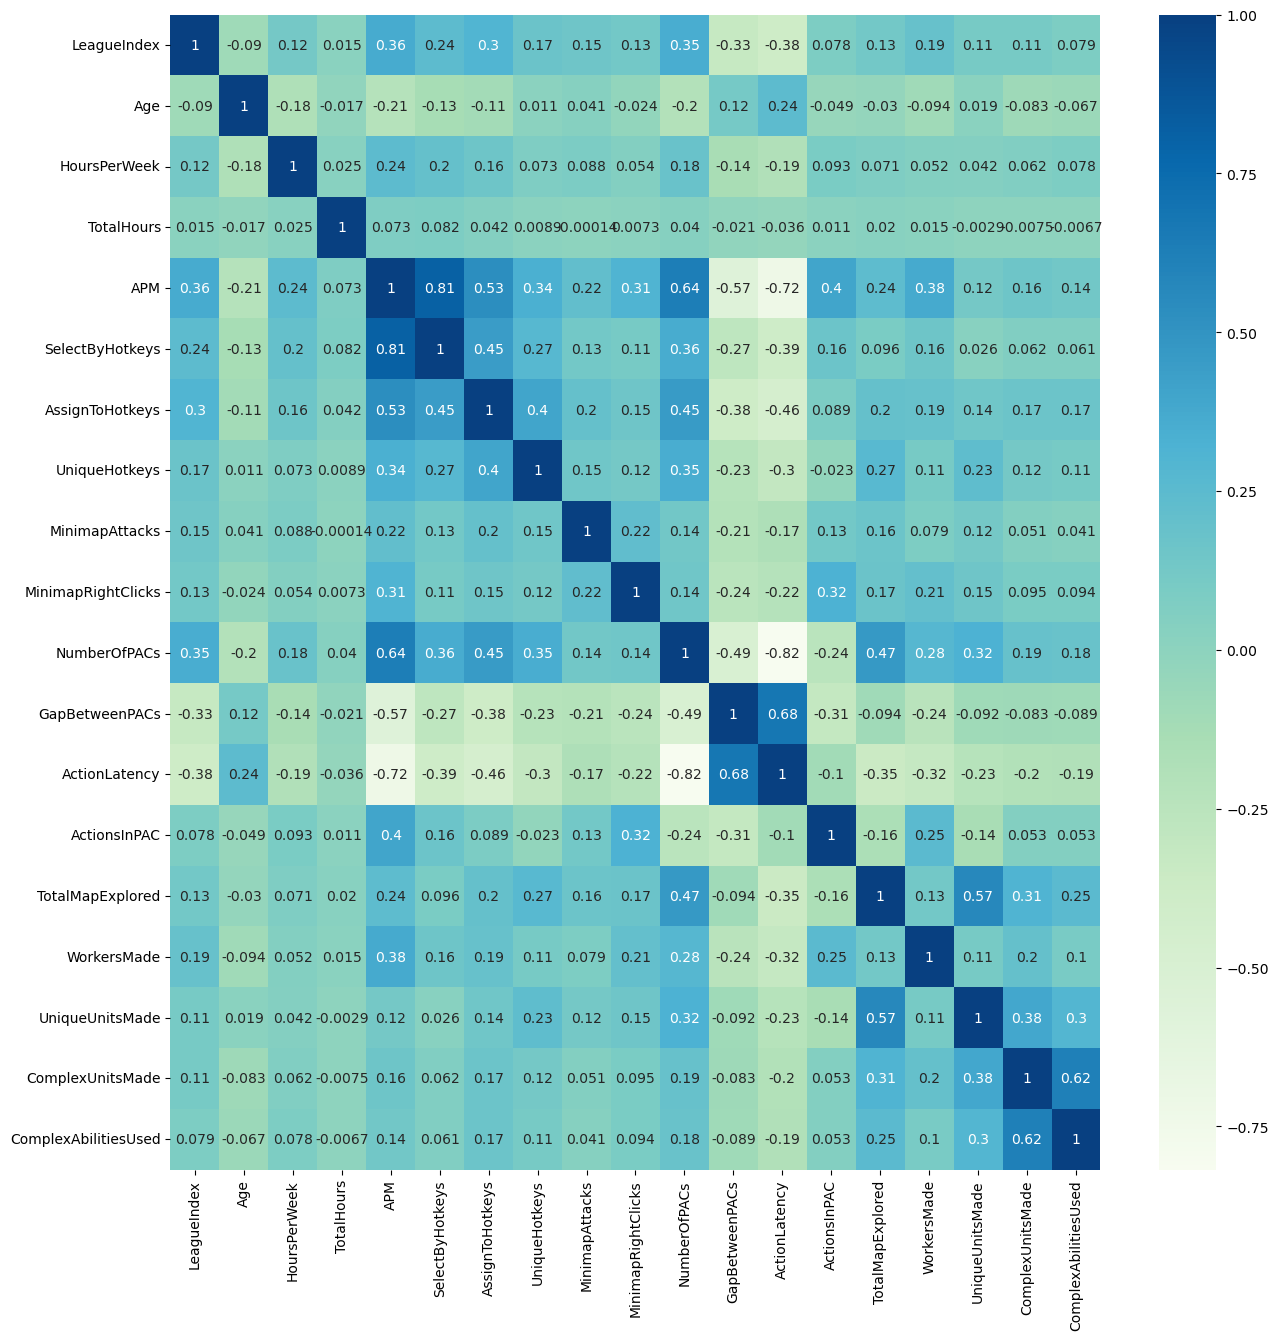

In [29]:
# ¿Hay correlación entre variables?
plt.figure(figsize =(15,15))
correlacion = df_num.corr()
sns.heatmap(correlacion, cmap = 'GnBu', annot = True)
plt.show()

APM, AssingToHotkeys, GapBetweenPACs, ActionLatency

Este método arroja valores similares. Sin embargo, al ver estos datos notamos que en league index hay un gran outlier por lo que decidimos eliminar las filas cuyos registros sean mayores a 18.

In [30]:
indexNames = df_tracks[df_tracks['LeagueIndex'] > 18].index
df_tracks = df_tracks.drop(indexNames)

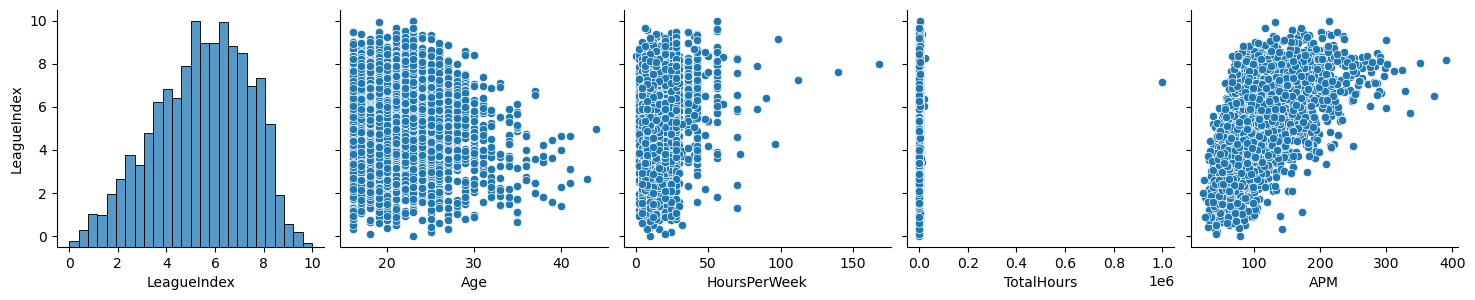

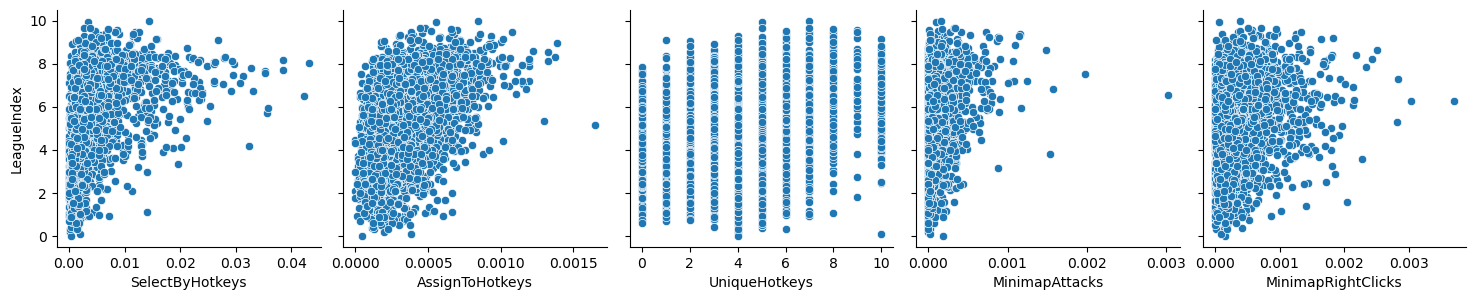

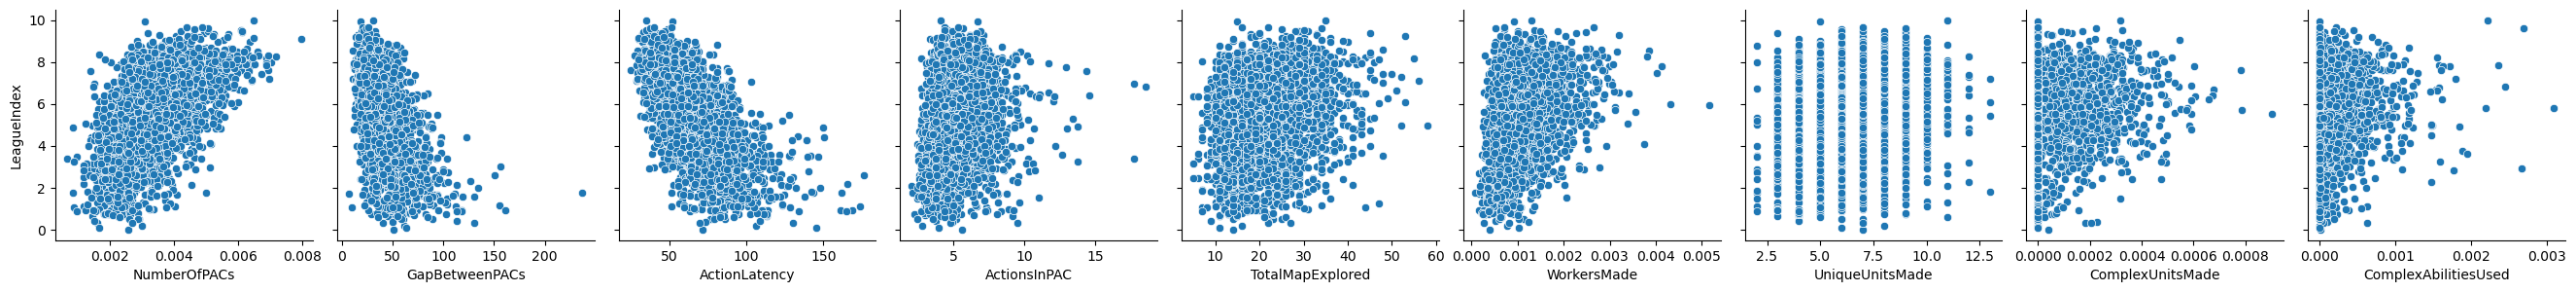

In [31]:
sns.pairplot(df_tracks, height=3, y_vars = 'LeagueIndex', x_vars = df_tracks.columns[0:5], kind='scatter')
sns.pairplot(df_tracks, height=3, y_vars = 'LeagueIndex', x_vars = df_tracks.columns[5:10], kind='scatter')
sns.pairplot(df_tracks, height=3, y_vars = 'LeagueIndex', x_vars = df_tracks.columns[10:], kind='scatter')
plt.show()

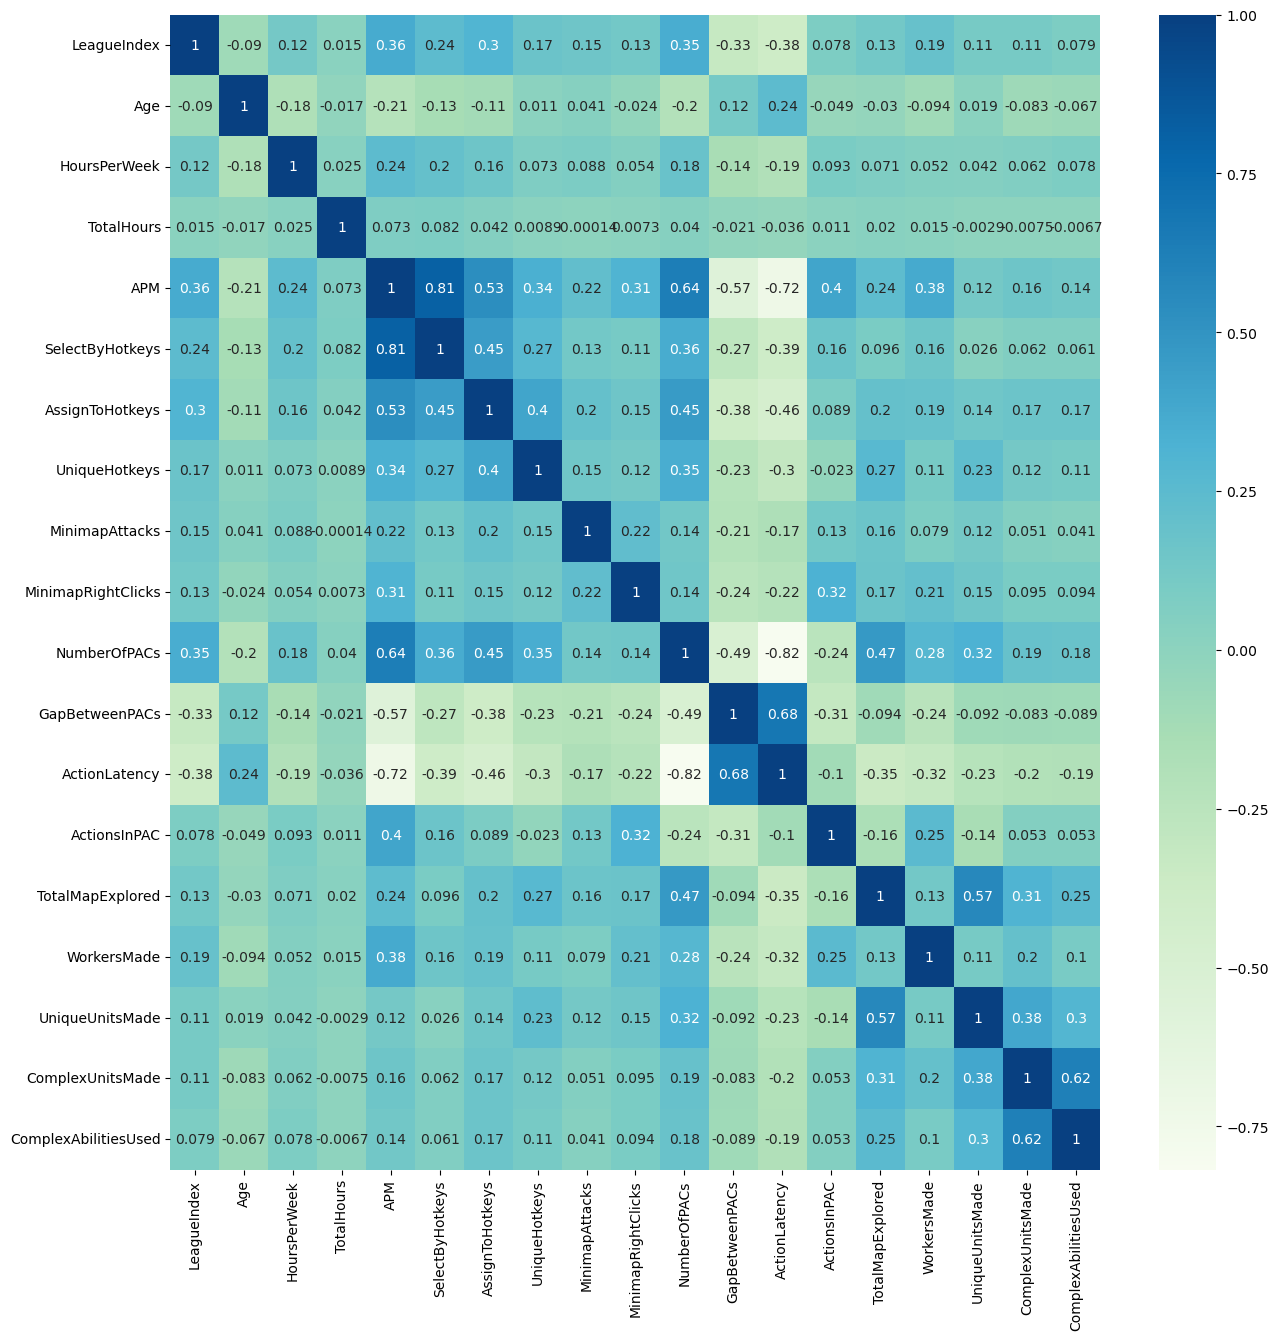

In [32]:
# ¿Hay correlación entre variables?
plt.figure(figsize =(15,15))
correlacion = df_num.corr()
sns.heatmap(correlacion, cmap = 'GnBu', annot = True)
plt.show()

## 4.Regresión Básica
Realizamos una regresión básica y luego la utilizamos para asignar la columna *LeagueIndex* de los datos recientes.

Se quiere generar un unico modelo que podamos exportar y que pueda ser usado en producción para asignar nuevos valores

In [33]:
# Preprocesamiento
# Se usa un transformador para seleccionar unicamente las columnas que se quieren usar
selected_cols = ['APM','AssignToHotkeys','GapBetweenPACs','ActionLatency']

pre = [('initial',ColumnTransformer([("selector", 'passthrough',selected_cols)])),]


In [34]:
# Modelo
model = [('model', LinearRegression())]

In [35]:
# Decalra el pipeline
pipeline = Pipeline(pre+model)

In [36]:
# Extraemos las variables explicativas y objetivo para entrenar
X = df_tracks.drop('LeagueIndex', axis = 1)
y = df_tracks['LeagueIndex']

pipeline = pipeline.fit(X,y)

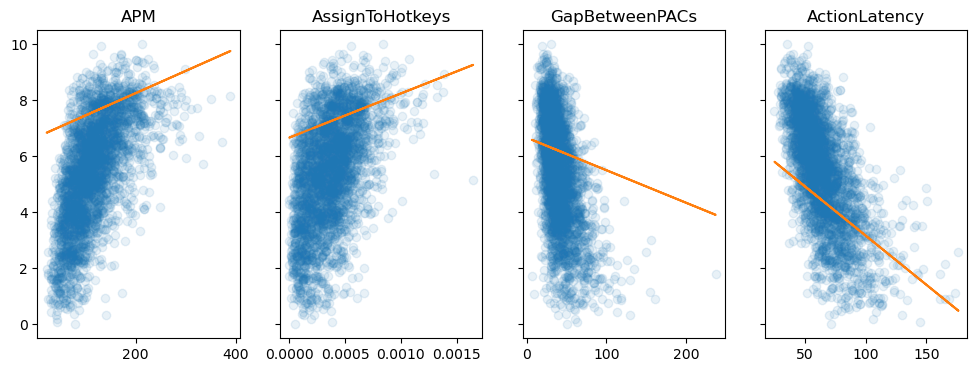

In [37]:
# Visualizamos la regresion lineal en cada dimension
f, axs = plt.subplots(1, len(selected_cols), sharey=True, figsize = (12,4))

for i in range(len(selected_cols)):

    pos_col = i
    col = selected_cols[pos_col]

    # Variable x
    x = X[col]
    # Pendiente
    m = pipeline['model'].coef_[pos_col]
    # Interceto
    b = pipeline['model'].intercept_

    axs[i].plot(x, y, 'o', alpha = 0.1)
    axs[i].plot(x, x*m + b)
    axs[i].set_title(col)
plt.show()

## 5. Coeficientes

Los coeficientes de la regresión nos pueden dar información sobre la relación entre las variables observadas y la variable objetivo.


In [38]:
pipeline['model'].coef_

array([ 7.93464487e-03,  1.57541714e+03, -1.16314446e-02, -3.50315534e-02])

In [39]:
# En DataFrame
pd.DataFrame({'columns':selected_cols, 'coef':pipeline['model'].coef_})

,columns,coef
0,APM,0.007935
1,AssignToHotkeys,1575.417138
2,GapBetweenPACs,-0.011631
3,ActionLatency,-0.035032


Vemos que los valores de los coeficientes son dificiles de leer pues no hemos normalizado los datos.

Realizamos una normalizacion de los datos para generar de nuevo un pipeline.


In [40]:
# Preprocesamiento
# Se usa un transformador para seleccionar unicamente las columnas que se quieren usar
selected_cols = ['APM','AssignToHotkeys','GapBetweenPACs','ActionLatency']

pre = [('initial',ColumnTransformer([("selector", 'passthrough',selected_cols)])),('scaler',MinMaxScaler())]

# Modelo
model = [('model', LinearRegression())]

# Declara el pipeline
pipeline = Pipeline(pre+model)

In [41]:
# Extraemos las variables explicativas y objetivo para entrenar
X = df_tracks.drop('LeagueIndex', axis = 1)
y = df_tracks['LeagueIndex']

pipeline = pipeline.fit(X,y)

In [42]:
# Vuelve a imprimir los coeficientes
pd.DataFrame({'columns':selected_cols, 'coef':pipeline['model'].coef_})


,columns,coef
0,APM,2.918139
1,AssignToHotkeys,2.596758
2,GapBetweenPACs,-2.680771
3,ActionLatency,-5.315670


In [43]:
# Ajustar el modelo para ver el reporte
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
# Mostrar las estadísticas del modelo
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            LeagueIndex   R-squared (uncentered):                   0.943
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              2838.
Date:                Mon, 27 Sep 2021   Prob (F-statistic):                        0.00
Time:                        19:25:44   Log-Likelihood:                         -5441.8
No. Observations:                3122   AIC:                                  1.092e+04
Df Residuals:                    3104   BIC:                                  1.103e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Age                      0.0255      0.006      4.224      0.000       0.014       0.037
HoursPerWeek             0.0115      0.002      5.310      0.000       0.007       0.016
TotalHours           -7.636e-07   1.39e-06     -0.549      0.583   -3.49e-06    1.97e-06
APM                     -0.0139      0.003     -4.715      0.000      -0.020      -0.008
SelectByHotkeys        112.8143     17.568      6.422      0.000      78.369     147.259
AssignToHotkeys       1156.8321    150.081      7.708      0.000     862.564    1451.100
UniqueHotkeys            0.0455      0.012      3.748      0.000       0.022       0.069
MinimapAttacks        1360.0251    163.719      8.307      0.000    1039.017    1681.033
MinimapRightClicks     -47.9231     77.990     -0.614      0.539    -200.840     104.994
NumberOfPACs          1155.2159     64.382     17.943      0.000    1028.981    1281.451
GapBetweenPACs          -0.0086      0.002     -4.012      0.000      -0.013      -0.004
ActionLatency           -0.0098      0.002     -4.180      0.000      -0.014      -0.005
ActionsInPAC             0.3822      0.037     10.286      0.000       0.309       0.455
TotalMapExplored        -0.0105      0.005     -2.312      0.021      -0.019      -0.002
WorkersMade            306.0410     54.020      5.665      0.000     200.122     411.960
UniqueUnitsMade         -0.0015      0.017     -0.090      0.928      -0.035       0.032
ComplexUnitsMade       180.1669    296.160      0.608      0.543    -400.523     760.857
ComplexAbilitiesUsed    -7.0790    118.636     -0.060      0.952    -239.692     225.534
==============================================================================
Omnibus:                        8.774   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.841
Skew:                          -0.130   Prob(JB):                       0.0120
Kurtosis:                       2.971   Cond. No.                     2.20e+08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.2e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Vemos que las 4 variables seleccionadas efectivamente tiene una relacion lineal por lo que se pueden incluir en nuestro modelo.

## 6. Exportar e Importar el Modelo 

In [44]:
# Usamos la lbreria joblib
filename = 'modelo.joblib'
# Se guarda
dump(pipeline, filename) 

['modelo.joblib']

In [45]:
# Se lee
p2 = load(filename)
p2

Pipeline(steps=[('initial',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['APM', 'AssignToHotkeys',
                                                   'GapBetweenPACs',
                                                   'ActionLatency'])])),
                ('scaler', MinMaxScaler()), ('model', LinearRegression())])

In [46]:
# Clasificamos los datos recientes
df_recent['LeagueIndex'] = p2.predict(df_recent)

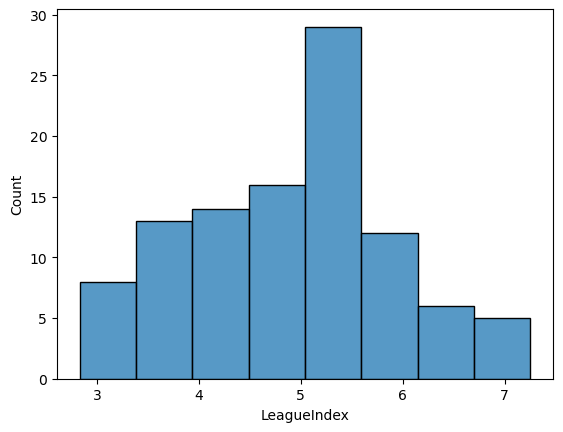

In [47]:
sns.histplot(df_recent['LeagueIndex'])
plt.show()

## 7. Métricas de un Modelo

### 7.1 Coeficiente de Determinación $R^2$

La primera métrica que tenemos es el coeficiente de determinación ($R^2$). Este valor indica que porcentaje de la varianza en la variable objetivo se puede explicar con las variables observadas. Este se define como:
$$ R^2 =  1 - \frac{\sum_{i=1}^{n} (y_i - f_i)^2}{\sum_{i=1}^{n} (y_i - \hat{y})^2}$$

donde $y_i$ es el elemento $i$ de la varaible objetivo, $f_i$ el elemento i de los valores predecidos y:

$$ \hat{y} = \frac{1}{n} \sum_{i=1}^{n} y_{i} $$

In [48]:
p2.score(X,y)

0.4757776721753365

Vemos que hasta el momento, tenemos un modelo que no es completamente lineal pero que claramente ya es mejor que el que se tenia en un inicio de 0.35.

### 7.2 Root-Mean-Square Error (RMSE) 
La segunda medida es la raiz del error cuadrático medio, definido como:

$$ RSME = \sqrt{\frac{\sum_{i=1}^{n} (y_i - f_i)^2}{n}} $$

In [49]:
y_true = y
y_predicted = p2.predict(X)

# Note que hay que sacarle la raiz al valor
np.sqrt(mse(y_true, y_predicted))

1.4032835984516734

Nos dice que en promedio, los valores se encuentran alejados 1.4 puntos del LeagueIndex que deberian ser clasificados.

## 8. Supuestos de la Regresión Lineal

### 8.1 Colinealidad
Es necesario que las columnas utilizadas no tengan (o tengan muy poca) colinealidad. La forma mas sencilla de hacer esto es con la matriz de correlación

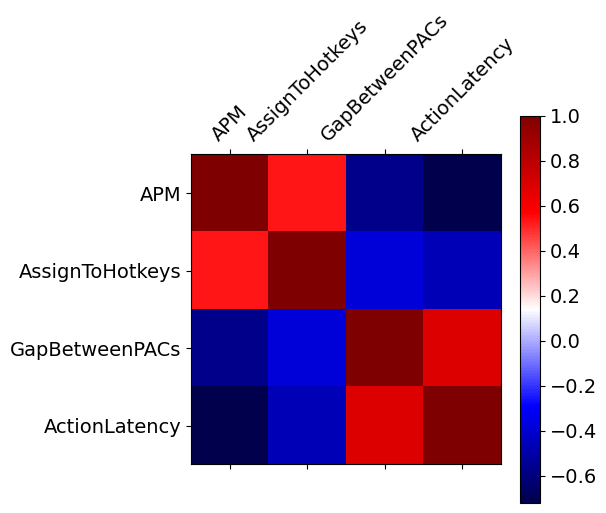

In [50]:
df_temp = df_tracks[selected_cols]


f = plt.figure(figsize=(5, 5))
plt.matshow(df_temp.corr(), fignum=f.number, cmap = 'seismic')
plt.xticks(range(df_temp.select_dtypes(['number']).shape[1]), df_temp.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_temp.select_dtypes(['number']).shape[1]), df_temp.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
_ = cb.ax.tick_params(labelsize=14)
plt.show()

Vemos que existe una alta colinealidad entre *APM*, *GapBetweenPACs* y *ActionLatency*. Sin embargo, las 4 de ellas tienen una colinealidad buena entre ellas.

### 8.2 Linealidad
Es necesario que la relación entre cada variable explicativa y la varable objetivo sea lineal. Muchas veces la mejor forma de hacer esto es visualmente:
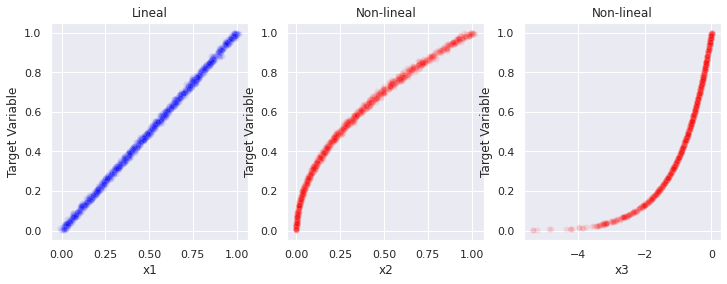

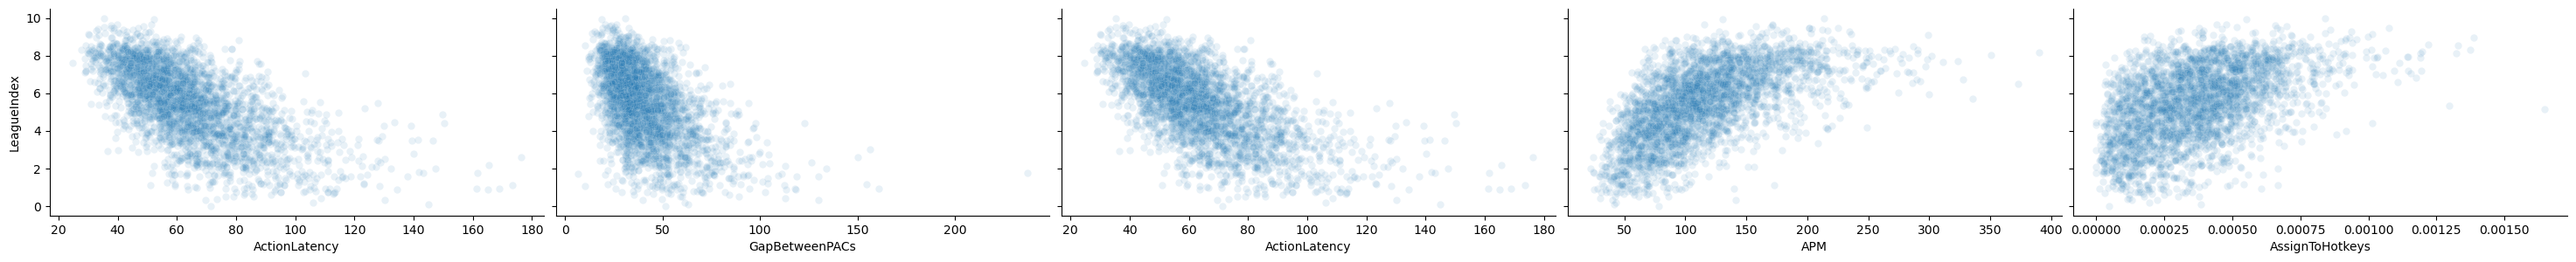

In [51]:
sns.pairplot(df_tracks, height=3, aspect = 2, y_vars = 'LeagueIndex', x_vars = ['ActionLatency','GapBetweenPACs','ActionLatency','APM','AssignToHotkeys'], kind='scatter', plot_kws = {'alpha':0.1})
plt.show()

### 8.3 Normalidad en los Errores

Otra suposición de la regresión lineal es que los errores tienen una distribución normal. Para esto se puede usar:
* Grafico de dispersión entre los errores y el valor predicto
* Grafico Q-Q

**Dispersión**
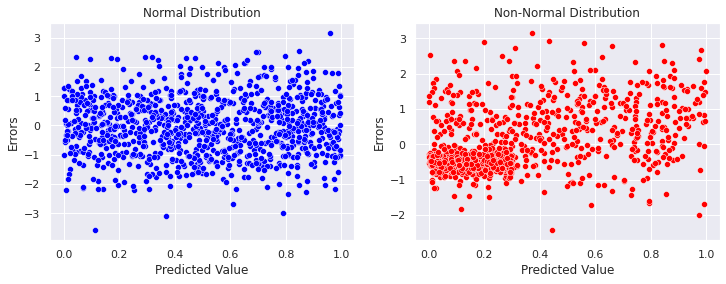

**Q-Q Plots**
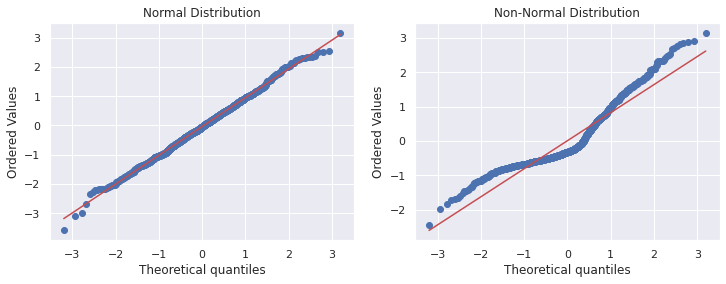

Veamos a ver como se ven estos graficos sobre nuestros datos

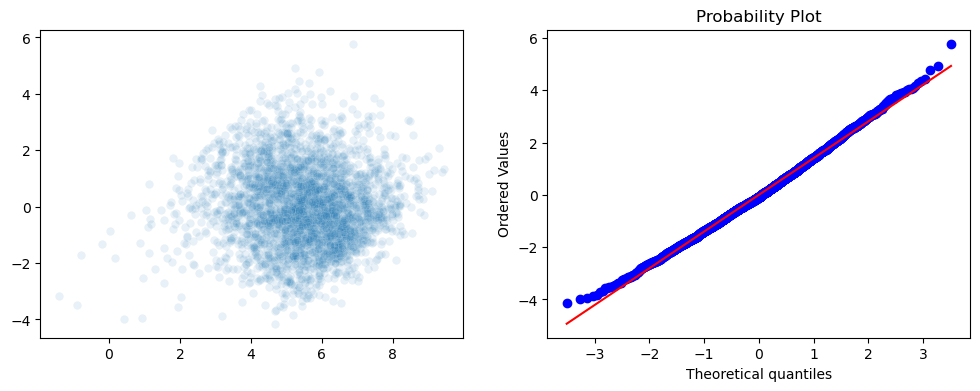

In [52]:
X = df_tracks.drop('LeagueIndex', axis = 1)
y = df_tracks['LeagueIndex']

# Calculamos los errores
errors = (p2.predict(X) - y).values

fig, axes = plt.subplots(1, 2, figsize = (12,4))

# Dispersión
sns.scatterplot(x = p2.predict(X), y = errors, alpha = 0.1, ax = axes[0])

# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes[1])
plt.show()

Vemos que tenemos una dispersion de distribucion normal.

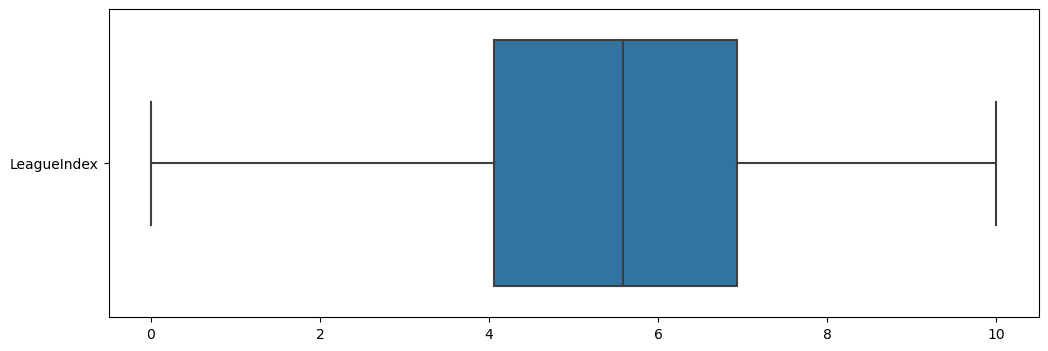

In [53]:
# Diagrama de caja
fig=plt.figure(figsize=(12,4))
ax = sns.boxplot(data= df_tracks[['LeagueIndex']], orient="h")
plt.show()

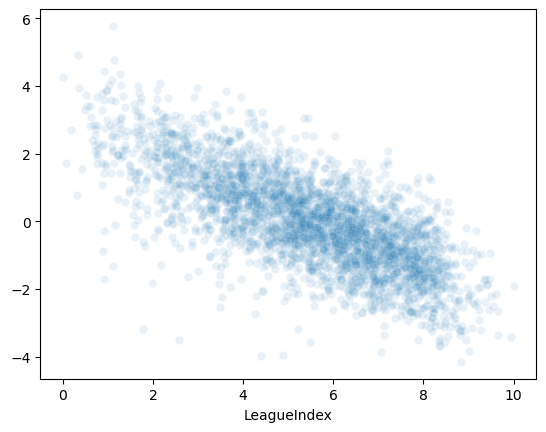

In [54]:
# Visualizamos nuestros datos
sns.scatterplot(data  = df_tracks, x = 'LeagueIndex', y = errors, alpha = 0.1)
plt.show()

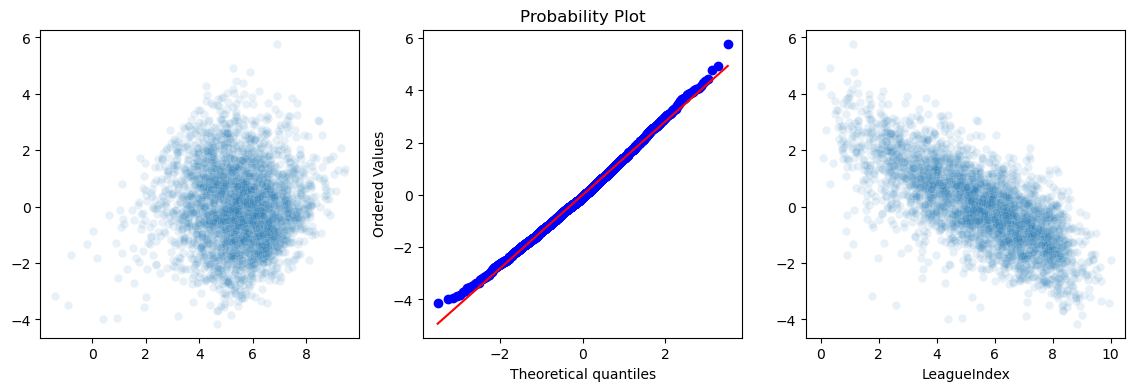

In [55]:
# Revisamos las graficas

# Calculamos los errores
errors = (p2.predict(X) - y).values

fig, axes = plt.subplots(1, 3, figsize = (14,4))

# Dispersión
sns.scatterplot(x = p2.predict(X), y = errors, alpha = 0.1, ax = axes[0])

# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes[1])

sns.scatterplot(data  = df_tracks, x = 'LeagueIndex', y = errors, alpha = 0.1, ax = axes[2])
plt.show()